In [1]:
! pip install transformers datasets evaluate
! pip install nlpaug nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible

## 数据加载和清洗

In [2]:
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.model_selection import KFold
import random
import numpy as np

health_ds = load_dataset('json', data_files='healthcare-consults.json')["train"]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
remove_labels = [2, 3, 5, 7]
filtered_ds = health_ds.filter(lambda example: example['label'] not in remove_labels)

unique_labels = sorted(set(filtered_ds['label']))
label_map = {old: new for new, old in enumerate(unique_labels)}

def remap_label(example):
    return {'label': label_map[example['label']]}

health_ds = filtered_ds.map(remap_label)

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [9]:
id2label = {
    0: "medication-side-effect",
    1: "insurance-related",
    2: "symptom-description",
    3: "pharmaceutical-use",
    4: "vaccine-related"
    }

In [4]:
health_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 90
})

## 数据增强

In [ ]:
import nltk
import nlpaug.augmenter.word as naw

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('popular')
nltk.download('averaged_perceptron_tagger_eng')

In [5]:
augmenter = naw.SynonymAug(aug_min=1, aug_max=3)

original_texts = health_ds['text']
original_labels = health_ds['label']

aug_texts = []
aug_labels = []

for text, label in zip(original_texts, original_labels):
    augmented_versions = augmenter.augment(text, n=2)
    aug_texts.extend(augmented_versions)
    aug_labels.extend([label] * len(augmented_versions))

all_texts = list(original_texts) + aug_texts
all_labels = list(original_labels) + aug_labels

health_ds = Dataset.from_dict({
    'text': all_texts,
    'label': all_labels
})

In [6]:
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:100]),
        'label': example['label']
    }


In [7]:
health_ds = health_ds.shuffle(seed=1111)

dataset_dict = health_ds.train_test_split(test_size=0.2, seed=1111)

health_ds = DatasetDict({
    "train": dataset_dict["train"],
    "val": dataset_dict["test"]
})

In [17]:
print(health_ds)
print(health_ds['train'][0])
print(health_ds['val'][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 216
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 54
    })
})
{'text': ['The new pediatric flu vaccine is reported to be highly effective in preventing cases of flu among children. Is it safe for my 7 - year - old to get the shot?', "I'm concerned about covering the out-of-network costs for my upcoming surgery. Will my insurance plan cover it?", "I ' m tactual sensation really unwell, I have a fever of 38 degrees Celsius and severe dresser pain when I cough. I ' m also experiencing gruffness of breath. I ' m worried I might have pneumonia or some kind of respiratory infection.", "I ' m experiencing symptoms of shortness of breath, chest pain and extreme fatigue after a recent flu contagion. I ' m worried that Iodin might have developed pneumonia. Can you please advise me on the best course of action to take?", 'I need help understanding my medical bill, can some

## 句子文本编码

In [10]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def preprocess_function(token):
    return tokenizer(token["text"], padding="max_length", truncation=True)

tokenized_dataset = health_ds.map(preprocess_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# print the frist 3 processed samples
tokenized_dataset['train'][:3]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

{'label': tensor([4, 1, 2]),
 'input_ids': tensor([[ 101, 1996, 2047,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0],
         [ 101, 1045, 1005,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

## 模型训练

In [11]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm.notebook import tqdm
import os
from transformers import DistilBertForSequenceClassification
import torch
import evaluate
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [40]:
def train_val(model, tokenized_dataset, epochs=3, bsz=8, lr=5e-3):

    train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=bsz, shuffle=True)
    test_dataloader = DataLoader(tokenized_dataset["val"], batch_size=bsz)


    optimizer = AdamW(model.parameters(), lr=lr)
    num_warmup_steps = int(0.1 * num_epochs * len(train_dataloader))

    lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,
                                                   num_training_steps=num_epochs * len(train_dataloader))

    train_acc_record = []
    train_loss_record = []
    test_acc_record = []

    for epoch in tqdm(range(num_epochs), desc="Train and Test", leave=True):

        model.train()
        train_correct, train_total = 0, 0
        for ids, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            if 'label' in batch:
                batch['labels'] = batch.pop('label')
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            if ids % 8 == 0:
              train_loss_record.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            predictions = torch.argmax(logits, dim=-1)
            train_correct += (predictions == batch["labels"]).sum().item()
            train_total += batch["labels"].size(0)

        train_acc = train_correct / train_total

        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                if 'label' in batch:
                    batch['labels'] = batch.pop('label')
                outputs = model(**batch)
                logits = outputs.logits

                predictions = torch.argmax(logits, dim=-1)
                test_correct += (predictions == batch["labels"]).sum().item()
                test_total += batch["labels"].size(0)

        test_acc = test_correct / test_total

        train_acc_record.append(train_acc)
        test_acc_record.append(test_acc)

        tqdm.write(f"Epoch {epoch + 1}: train acc = {train_acc:.4f}, test acc = {test_acc:.4f}")
    return train_acc_record, test_acc_record, train_loss_record


In [37]:

num_epochs = 9
bsz = 3
lr = 5e-3


In [41]:

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)
for param in model.distilbert.parameters():
    param.requires_grad = False
model.to(device)

train_acc, test_acc, train_loss = train_val(model, tokenized_dataset, num_epochs, bsz, lr)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train and Test:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1: train acc = 0.4907, test acc = 0.6667
Epoch 2: train acc = 0.6898, test acc = 0.7593
Epoch 3: train acc = 0.7870, test acc = 0.7778
Epoch 4: train acc = 0.8796, test acc = 0.8889
Epoch 5: train acc = 0.8935, test acc = 0.9074
Epoch 6: train acc = 0.9352, test acc = 0.8519
Epoch 7: train acc = 0.9537, test acc = 0.8704
Epoch 8: train acc = 0.9491, test acc = 0.9259
Epoch 9: train acc = 0.9769, test acc = 0.9444


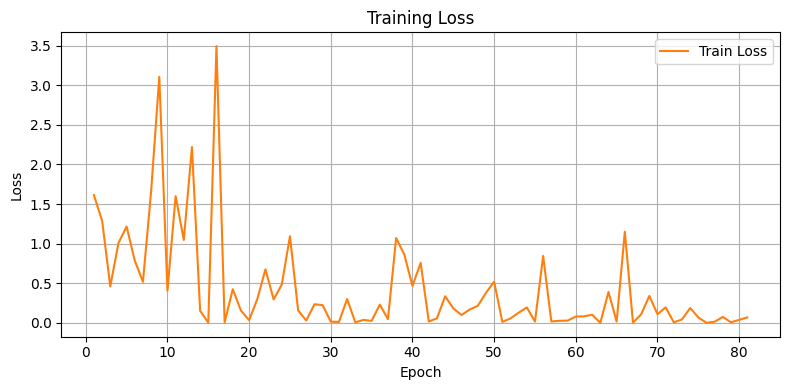

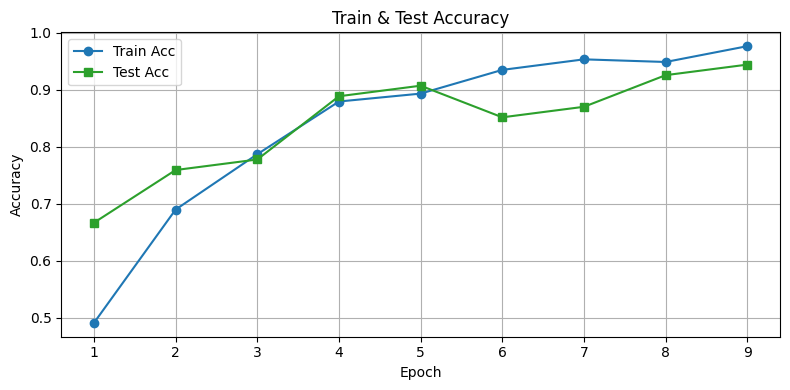

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Acc', color='tab:blue', marker='o')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Acc', color='tab:green', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 预测

In [20]:
test_language = [
    "The new pediatric flu vaccine is reported to be highly effective in preventing cases of flu among children. Is it safe for my 7-year-old to get the shot?",
    "I have been taking a new medication and my skin has been breaking out terribly, especially on my face and chest. Can this be a side effect of the medication?",
    "I have been experiencing recurring headaches and I am concerned that it might be related to my diet. Can I discuss with my doctor the potential impact of too much caffeine and sugar on my body?"
]
prediction_label = []

model.eval()
for news in test_language:
    inputs = tokenizer(news, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

    prediction_label.append(predicted_class)

for ids, prediction_label in enumerate(prediction_label):
    print(f"The class of consult '{test_language[ids]}' is {id2label[prediction_label]} \n")


The class of consult 'The new pediatric flu vaccine is reported to be highly effective in preventing cases of flu among children. Is it safe for my 7-year-old to get the shot?' is vaccine-related 

The class of consult 'I have been taking a new medication and my skin has been breaking out terribly, especially on my face and chest. Can this be a side effect of the medication?' is medication-side-effect 

The class of consult 'I have been experiencing recurring headaches and I am concerned that it might be related to my diet. Can I discuss with my doctor the potential impact of too much caffeine and sugar on my body?' is symptom-description 

